In [1]:
from thefuzz import fuzz
from thefuzz import process

In [10]:
import base64

In [68]:
import pandas as pd
import numpy as np

import re
import pymorphy2
import pandas as pd

import nltk
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ipuzanov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ipuzanov\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ipuzanov\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [223]:
from nltk.util import ngrams

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

В качестве примера возьмем 3 выборки новостных статей:
1. Обычная неделя с 31.03.2004 по 7.04.2004
2. Неделя с отставкой Шеварнадзе с 18.11.2003 по 24.11.2003
2. Неделя с взрывом в Ессентуках и выборами в Госдуму с 01.12.2003 по 09.12.2003

In [178]:
norm_week = pd.read_xml('./docs/news-080404.xml', encoding='windows-1251')
shevard_week = pd.read_xml('./docs/news-shevard.xml', encoding='windows-1251')
duma_week = pd.read_xml('./docs/news-vybory.xml', encoding='windows-1251')

In [179]:
NEWS_COUNT = 100

In [180]:
norm_week = norm_week[1:NEWS_COUNT+1]
shevard_week = shevard_week[1:NEWS_COUNT+1]
duma_week = duma_week[1:NEWS_COUNT+1]

In [181]:
def prepare_df(df: pd.DataFrame) -> pd.DataFrame:
    df['content'] = df['content'].map(lambda x: base64.b64decode(x).decode('cp1251'))
    df['subject'] = df['subject'].map(lambda x: base64.b64decode(x).decode('cp1251'))
    df['agency'] = df['agency'].map(lambda x: base64.b64decode(x).decode('cp1251'))
    return df[['subject', 'agency', 'content']]

In [182]:
norm_week = prepare_df(norm_week)
shevard_week = prepare_df(shevard_week)
duma_week = prepare_df(duma_week)

Выполним исследование для обычной недели

План исследования:
1. Канонизировать текст (удалить предлоги, союза, знаки препинания, привести к нормальной форме)
2. Разбить на шинглы
3. Выполнить нечеткое сравнение шингов между документами
4. Определить дубликаты
5. Выделить кластеры

In [183]:
norm_week.head()

,subject,agency,content
1,Кудрин: Министры смогут сами создавать межведо...,грани.ру,Министр финансов РФ Алексей Кудрин предложил п...
2,Иностранные журналисты опасны для Минприроды,грани.ру,Министерство природных ресурсов распорядилось ...
3,В районе Эль-Фаллуджи иракские повстанцы снова...,грани.ру,В четверг неподалеку от Эль-Фаллуджи иракские ...
4,Солярий: за и против,правда.ru,Загорать можно и зимой - для этого достаточно ...
5,Фурункул на лице. Консультация специалиста,правда.ru,На вопросы наших читательниц о гнойных воспале...


In [184]:
morph = pymorphy2.MorphAnalyzer()

In [185]:
def get_morph_text(input_text):
    text = re.sub('[^а-яА-Я]', ' ', input_text.replace('\\n', ''))
    text = nltk.word_tokenize(text)
    clear_text = []
    for word in text:
        normal_word = morph.parse(word)[0].normal_form
        if normal_word not in stopwords.words('russian'):
            clear_text.append(normal_word)

    return ' '.join(clear_text)

In [186]:
norm_week['norm_news'] = [get_morph_text(news) for news in norm_week['content']]

In [187]:
norm_week['news_words_count'] = norm_week['norm_news'].map(lambda x: len(x.split(' ')))

In [188]:
norm_week.head()

,subject,agency,content,norm_news,news_words_count
1,Кудрин: Министры смогут сами создавать межведо...,грани.ру,Министр финансов РФ Алексей Кудрин предложил п...,министр финансы рф алексей кудрин предложить п...,75
2,Иностранные журналисты опасны для Минприроды,грани.ру,Министерство природных ресурсов распорядилось ...,министерство природный ресурс распорядиться до...,103
3,В районе Эль-Фаллуджи иракские повстанцы снова...,грани.ру,В четверг неподалеку от Эль-Фаллуджи иракские ...,четверг неподалёку эль фаллуджи иракский повст...,50
4,Солярий: за и против,правда.ru,Загорать можно и зимой - для этого достаточно ...,загорать зимой это достаточно пара неделя ходи...,702
5,Фурункул на лице. Консультация специалиста,правда.ru,На вопросы наших читательниц о гнойных воспале...,вопрос наш читательница гнойный воспаление кож...,723


<Axes: >

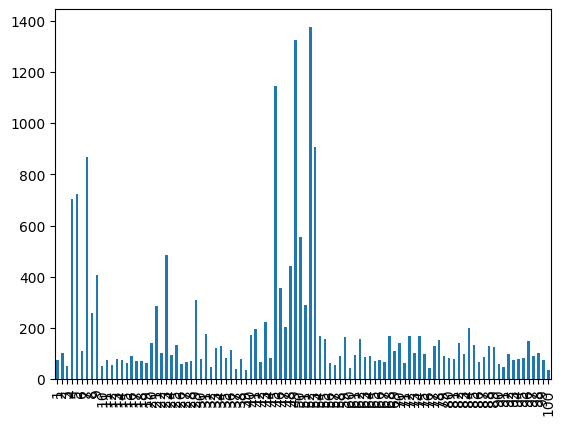

In [189]:
norm_week['news_words_count'].plot.bar()

In [190]:
print(f"Медианное значение длины новости: {norm_week['news_words_count'].median()}")

Медианное значение длины новости: 96.5


Возьмем шингл длинной 25

In [191]:
SHINGLE_LEN = 25

In [192]:
print(f"""
      Медианное значение количества шинглов: {norm_week['news_words_count'].median()-SHINGLE_LEN+1}
      Максимальное значение: {norm_week['news_words_count'].max()-SHINGLE_LEN+1}
      Минимальное значение: {norm_week['news_words_count'].min()-SHINGLE_LEN+1}
""")


      Медианное значение количества шинглов: 72.5
      Максимальное значение: 1353
      Минимальное значение: 11



In [193]:
shingles_matrix = list(norm_week['norm_news'].map(lambda x: list(ngrams(x.split(' '), SHINGLE_LEN))))

In [194]:
news_proximity_matrix = np.zeros((NEWS_COUNT, NEWS_COUNT))

# сравниваем все новости друг с другом
for first_index in range(NEWS_COUNT):
    for second_index in range(first_index + 1, NEWS_COUNT):
        news_proximities = []

        # сравниваем все шинглы внутри двух новостей друг с другом
        for shingle_first in shingles_matrix[first_index]:
            for shingle_second in shingles_matrix[second_index]:
                news_proximities.append(fuzz.ratio(shingle_first, shingle_second))
        
        # записываем среднее значение близости в матрицу
        news_proximity = round(np.mean(news_proximities), 2)
        news_proximity_matrix[first_index][second_index] = news_proximity
        news_proximity_matrix[second_index][first_index] = news_proximity
        

In [195]:
print(f"Максимальное значение близости: {np.max(news_proximity_matrix)}")

Максимальное значение близости: 20.3


<Axes: >

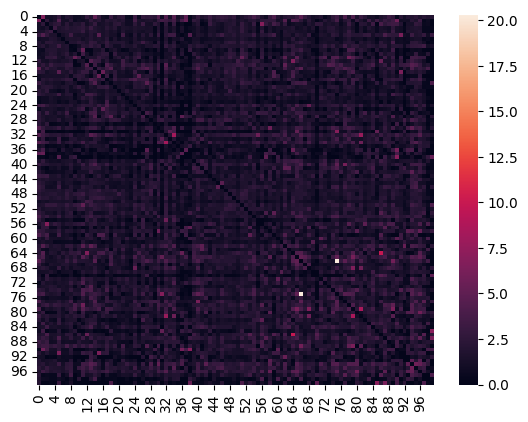

In [196]:
sns.heatmap(news_proximity_matrix)

In [197]:
def plot_frequency_count(matrix):
    unique, counts = np.unique(matrix, return_counts=True)
    if len(unique) % 2 != 0:
        unique = unique[1:]
        counts = counts[1:]

    data = np.array([unique, counts]).T

    y = data[:,1].reshape(-1,2).sum(axis=1)
    x = data[:,0].reshape(-1,2).mean(axis=1)

    plt.bar(x, y)
    plt.show()

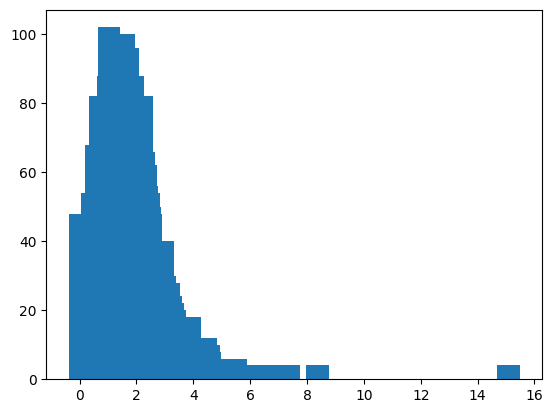

In [198]:
plot_frequency_count(news_proximity_matrix)

In [317]:
for i in range(NEWS_COUNT):
    for j in range(i+1, NEWS_COUNT):
        try:
            if news_proximity_matrix[i][j] > 8:
                print(
                    f"Схожие новости:\n" \
                    f"1. {norm_week.iloc[i]['agency']}\t{norm_week.iloc[i]['content'][:200]}\n" \
                    f"2. {norm_week.iloc[i]['agency']}\t{norm_week.iloc[j]['content'][:200]}\n"
                )
        except IndexError:
            continue

Схожие новости:
1. росбалт	МОСКВА, 2 апреля.
Основная задача Аграрной партии России - консолидация сил и выдвижение четкой программы, считает заместитель председателя партии Алексей Чепа.
Об этом он сообщил в пятницу на брифинг
2. росбалт	МОСКВА, 2 апреля.
Финансовые нарушения в Аграрной партии России вызваны "бездеятельностью некоторых ее членов", считает заместитель председателя АПР Алексей Чепа.
Об этом он сообщил в пятницу на брифи

Схожие новости:
1. росбалт	САНКТ-ПЕТЕРБУРГ, 2 апреля.
Российский кинематограф может спасти интеллигентный зритель, считает режиссер Андрей Прошкин ("Спартак и Калашников").
Об этом он заявил сегодня на пресс-конференции, посвящ
2. росбалт	САНКТ-ПЕТЕРБУРГ, 2 апреля.
"Одна из задач российского кино - показывать нашу фантастическую страну", - заявил сегодня на пресс-конференции, посвященной петербургской премьере фильма "Игры мотыльков", 

Схожие новости:
1. росбалт	САНКТ-ПЕТЕРБУРГ, 2 апреля.
"Министром номер один в российском правительстве должен быть мин

Можно увидеть, что распределение достаточно сбалансировано, большая часть значений близости находится в диапазоне [0, 3]

In [224]:
norm_distance_matrix = 100 - news_proximity_matrix

In [225]:
norm_labels = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='precomputed', linkage='single').fit_predict(norm_distance_matrix)

In [226]:
def plot_scatter(X, color, alpha=0.5):
    return plt.scatter(X[:, 0], X[:, 1], c=color, alpha=alpha, edgecolor="k")

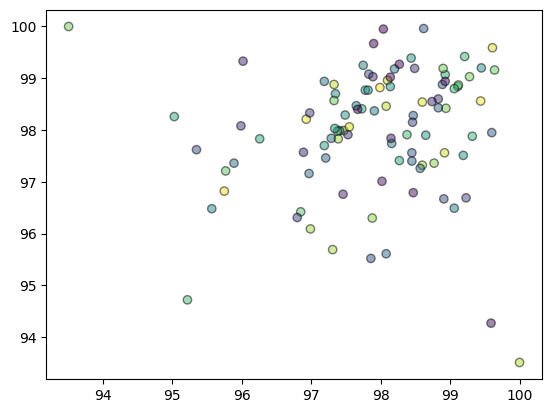

In [227]:
plot_scatter(norm_distance_matrix, norm_labels)

Как и ожидалось, среди новостей нет четких кластеров

Выполним аналогичные действия для других выборок новостей

In [199]:
shevard_week.head()

,subject,agency,content
1,Председатель Комитета Госдумы России по делам ...,regnum,25 ноября в Бурятии будут встречать председате...
2,50% продавцов Казани не имеют спецодежды,regnum,В каких условиях трудятся продавцы казанских м...
3,Одним из поставщиков газа на рынки Свердловско...,накануне.ru,Конкуренция поставщиков газа на рынке Свердлов...
4,"Повестка дня на 18 ноября - Тюменская область,...",newsprom.ru,18 ноября в Тюмени в совместном пресс-центре И...
5,Задолженность сельхозпредприятий Вельского рай...,regnum,На сегодняшний день задолженность сельхозпредп...


In [279]:
shevard_week['norm_news'] = [get_morph_text(news) for news in shevard_week['content']]
shevard_shingles_matrix = list(shevard_week['norm_news'].map(lambda x: list(ngrams(x.split(' '), SHINGLE_LEN))))

shevard_news_proximity_matrix = np.zeros((NEWS_COUNT, NEWS_COUNT))

# сравниваем все новости друг с другом
for first_index in range(NEWS_COUNT):
    for second_index in range(first_index + 1, NEWS_COUNT):
        news_proximities = []

        # сравниваем все шинглы внутри двух новостей друг с другом
        for shingle_first in shevard_shingles_matrix[first_index]:
            for shingle_second in shevard_shingles_matrix[second_index]:
                news_proximities.append(fuzz.ratio(shingle_first, shingle_second))
        
        # записываем среднее значение близости в матрицу
        news_proximity = round(np.mean(news_proximities), 2)
        shevard_news_proximity_matrix[first_index][second_index] = news_proximity
        shevard_news_proximity_matrix[second_index][first_index] = news_proximity
        

c:\Users\ipuzanov\PycharmProjects\BMSTU\venv\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ipuzanov\PycharmProjects\BMSTU\venv\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Пример на 30 новостях

In [142]:
print(f"Максимальное значение близости для новостей на фоне отставки Шеварнадзе: {np.max(shevard_news_proximity_matrix)}")

Максимальное значение близости для новостей на фоне отставки Шеварнадзе: 14.71


<Axes: >

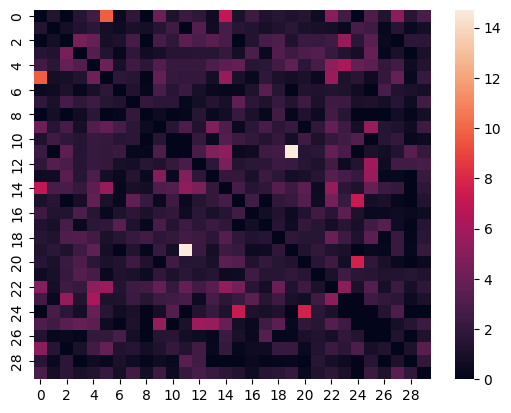

In [143]:
sns.heatmap(shevard_news_proximity_matrix)

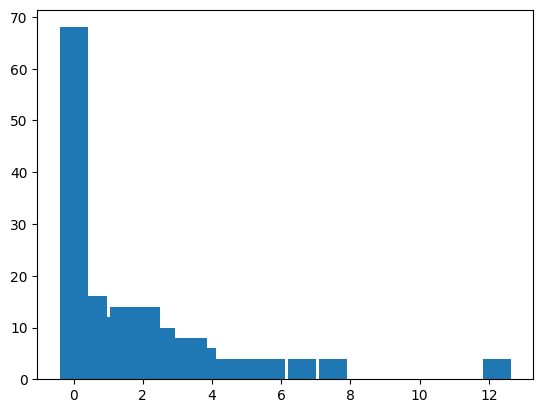

In [176]:
plot_frequency_count(shevard_news_proximity_matrix)

Пример на 100 новостях

In [293]:
# удаляем неподсчитанные значения
indexes = set()
for i in range(shevard_news_proximity_matrix.shape[0]):
    if np.isnan(shevard_news_proximity_matrix[i][0]):
        indexes.add(i)

for i in indexes:
    shevard_news_proximity_matrix[i][i] = np.nan

shevard_news_proximity_matrix = shevard_news_proximity_matrix[~np.isnan(shevard_news_proximity_matrix).all(axis=1),:]
shevard_news_proximity_matrix = shevard_news_proximity_matrix[:,~np.isnan(shevard_news_proximity_matrix).all(axis=0)]

In [294]:
print(f"Максимальное значение близости для новостей на фоне отставки Шеварнадзе: {np.max(shevard_news_proximity_matrix)}")

Максимальное значение близости для новостей на фоне отставки Шеварнадзе: 20.29


<Axes: >

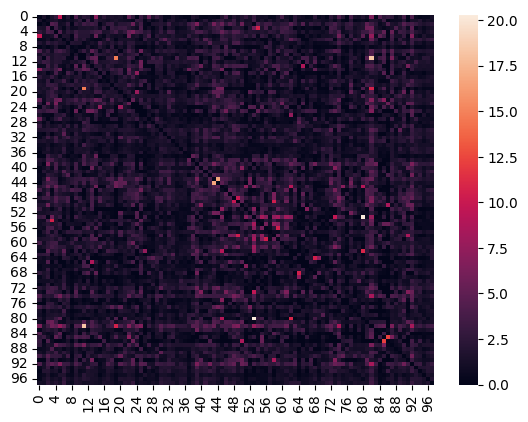

In [295]:
sns.heatmap(shevard_news_proximity_matrix)

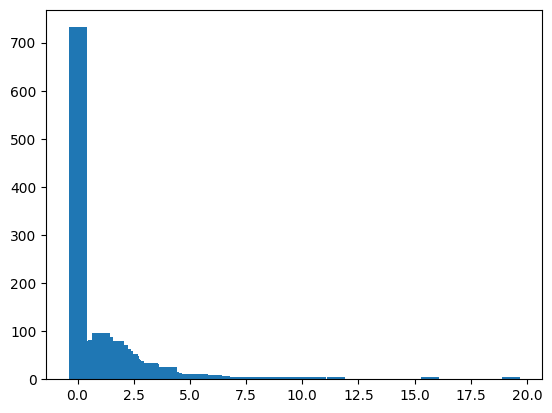

In [296]:
plot_frequency_count(shevard_news_proximity_matrix)

In [315]:
for i in range(NEWS_COUNT):
    for j in range(i+1, NEWS_COUNT):
        try:
            if shevard_news_proximity_matrix[i][j] > 15:
                print(
                    f"Схожие новости:\n" \
                    f"1. {shevard_week.iloc[i]['agency']}\t{shevard_week.iloc[i]['content'][:200]}\n" \
                    f"2. {shevard_week.iloc[i]['agency']}\t{shevard_week.iloc[j]['content'][:200]}\n"
                )
        except IndexError:
            continue

Схожие новости:
1. regnum	В Алексинском районе Тульской области злоумышленники разобрали 80 метров железнодорожного пути, передает радиостанция "Маяк-24-Тула".
Они хотели таким образом заработать деньги, сдав рельсы в металлол
2. regnum	Во Владимире определились победители чемпионата Министерства юстиции России по борьбе самбо и Всероссийского турнира на кубок Александра Невского.
Участие в традиционных соревнованиях по самбо приняли

Схожие новости:
1. regnum	Ученик 11 класса города Алзамая Андрей Павлов стал лучшим в областном конкурсе "Лучший ученик года".
Ему был вручен персональный компьютер.
Еще девять юных лауреатов конкурса получили видеокамеры.
Наг
2. regnum	2-4 декабря 2003 года в Иркутске пройдет областной смотр-конкурс "Студент года-2003".
Об этом сообщает пресс-центр Главного управления общего и профессионального образования Иркутской области.
Традици

Схожие новости:
1. newsprom.ru	24 ноября в Корее стартовал первый этап кубка мира по плаванию.
Как сообщили корреспонденту

В данной выборке видно, что есть сильные дубликаты (около 16% и 19%), но в остальном статьи не похожи друг на друга

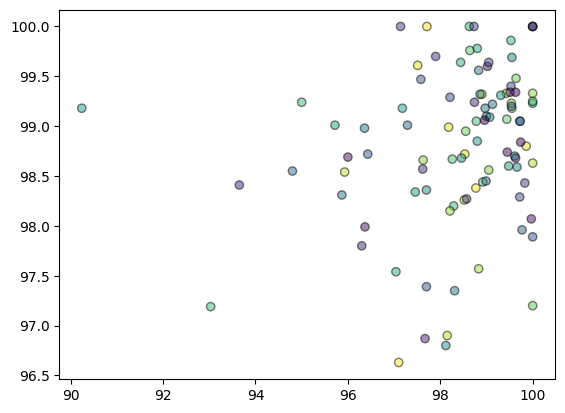

In [297]:
shevard_distance_matrix = 100 - shevard_news_proximity_matrix
shevard_labels = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='precomputed', linkage='single').fit_predict(shevard_distance_matrix)
plot_scatter(shevard_distance_matrix, shevard_labels)

In [298]:
duma_week.head()

,subject,agency,content
1,Восстановят колокольню храма Трех Исповедников...,regnum,6 декабря в 11.00 около храма Трех Исповеднико...
2,В Петербурге грабители напали на кафе,росбалт,"САНКТ-ПЕТЕРБУРГ, 3 декабря.\nВ Санкт-Петербург..."
3,"Доллар падает, несмотря на рост американской э...",росбалт,"ТОКИО, 3 декабря.\nДоллар достиг рекордно низк..."
4,Берлинские студенты 4 часа удерживали здание г...,росбалт,"БЕРЛИН, 3 декабря.\nСтуденты трех университето..."
5,Американцы поднимают золото с затонувшего в XI...,росбалт,"ТАМПА, 3 декабря.\nАмериканцы исследуют затону..."


In [299]:
duma_week['norm_news'] = [get_morph_text(news) for news in duma_week['content']]
duma_shingles_matrix = list(duma_week['norm_news'].map(lambda x: list(ngrams(x.split(' '), SHINGLE_LEN))))

duma_news_proximity_matrix = np.zeros((NEWS_COUNT, NEWS_COUNT))

# сравниваем все новости друг с другом
for first_index in range(NEWS_COUNT):
    for second_index in range(first_index + 1, NEWS_COUNT):
        news_proximities = []

        # сравниваем все шинглы внутри двух новостей друг с другом
        for shingle_first in duma_shingles_matrix[first_index]:
            for shingle_second in duma_shingles_matrix[second_index]:
                news_proximities.append(fuzz.ratio(shingle_first, shingle_second))
        
        # записываем среднее значение близости в матрицу
        news_proximity = round(np.mean(news_proximities), 2)
        duma_news_proximity_matrix[first_index][second_index] = news_proximity
        duma_news_proximity_matrix[second_index][first_index] = news_proximity
        

c:\Users\ipuzanov\PycharmProjects\BMSTU\venv\Lib\site-packages\numpy\core\fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\ipuzanov\PycharmProjects\BMSTU\venv\Lib\site-packages\numpy\core\_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [304]:
# удаляем неподсчитанные значения
indexes = set()
for i in range(duma_news_proximity_matrix.shape[0]):
    if np.isnan(duma_news_proximity_matrix[i][0]):
        indexes.add(i)

for i in indexes:
    duma_news_proximity_matrix[i][i] = np.nan

duma_news_proximity_matrix = duma_news_proximity_matrix[~np.isnan(duma_news_proximity_matrix).all(axis=1),:]
duma_news_proximity_matrix = duma_news_proximity_matrix[:,~np.isnan(duma_news_proximity_matrix).all(axis=0)]

In [305]:
print(f"Максимальное значение близости для новостей на взрыва в Ессентуках и выборов в Госдуму: {np.max(duma_news_proximity_matrix)}")

Максимальное значение близости для новостей на взрыва в Ессентуках и выборов в Госдуму: 33.05


<Axes: >

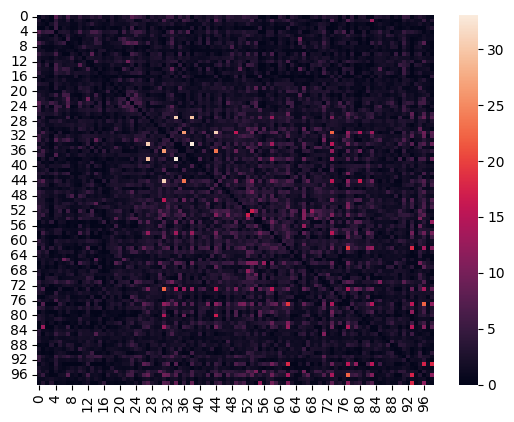

In [306]:
sns.heatmap(duma_news_proximity_matrix)

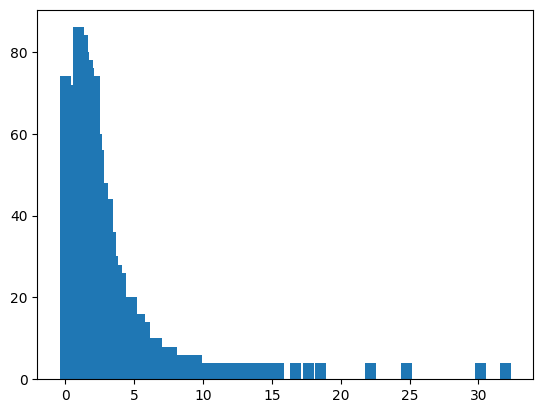

In [307]:
plot_frequency_count(duma_news_proximity_matrix)

In [313]:
for i in range(NEWS_COUNT):
    for j in range(i+1, NEWS_COUNT):
        try:
            if duma_news_proximity_matrix[i][j] > 15:
                print(
                    f"Схожие новости:\n" \
                    f"1. {duma_week.iloc[i]['agency']}\t{duma_week.iloc[i]['content'][:200]}\n" \
                    f"2. {duma_week.iloc[i]['agency']}\t{duma_week.iloc[j]['content'][:200]}\n"
                )
        except IndexError:
            continue

Схожие новости:
1. росбалт	ГРОЗНЫЙ, 9 декабря.
В Грозном задержаны два активных участника незаконных вооруженных формирований Рауф Демильханов и Ваха Магомедов.
Как сообщили во вторник корреспонденту "Росбалта" в пресс-службе Г
2. росбалт	СТОКГОЛЬМ, 9 декабря.
Затраты шведского государства на принудительную депортацию из страны людей, просивших убежище в Швеции, но не получивших его, значительно возросли в текущем году.
Об этом сообщил

Схожие новости:
1. росбалт	ГРОЗНЫЙ, 9 декабря.
В Грозном задержаны два активных участника незаконных вооруженных формирований Рауф Демильханов и Ваха Магомедов.
Как сообщили во вторник корреспонденту "Росбалта" в пресс-службе Г
2. росбалт	СТОКГОЛЬМ, 9 декабря.
Российский танкер "Герои Севастополя", вышедший из латвийского порта Вентспилс в минувшую субботу и находившийся в понедельник вечером в районе пролива Каттегат в Балтийском море

Схожие новости:
1. росбалт	МОСКВА, 9 декабря.
По уточненным данным, в результате взрыва в Москве ранены 8 человек.
Как

В данной выборке видим больше схожих новостей

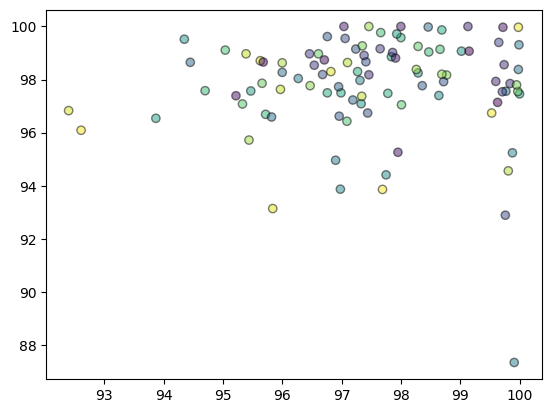

In [308]:
duma_distance_matrix = 100 - duma_news_proximity_matrix
duma_labels = AgglomerativeClustering(distance_threshold=0, n_clusters=None, metric='precomputed', linkage='single').fit_predict(duma_distance_matrix)
plot_scatter(duma_distance_matrix, duma_labels)

(Рисунок плохой, но можно заметить) Можно заметить, что элементы одного кластера близки друг к другу (зеленые, фиолетовые и голубые последовательности)